In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
%matplotlib inline

[*********************100%***********************]  1 of 1 completed


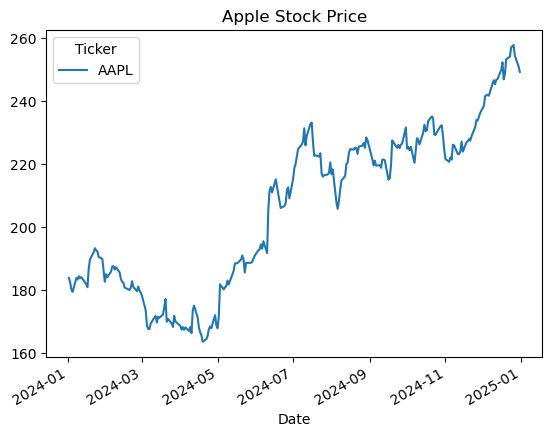

In [2]:
### Fetch annualhistorical stock data for Apple Inc. (AAPL)

data = yf.download("AAPL", start="2024-01-01", end="2025-01-01", interval="1d")

### Display the close price data
data['Close'].plot(title='Apple Stock Price')
plt.savefig("Figure_1_warm_up.png", dpi=300, bbox_inches='tight')
plt.show()

In [3]:
### Print the first five rows of the data
print(data.head())

Price            Close        High         Low        Open    Volume
Ticker            AAPL        AAPL        AAPL        AAPL      AAPL
Date                                                                
2024-01-02  183.903198  186.677005  182.169571  185.399066  82488700
2024-01-03  182.526215  184.140970  181.713879  182.496496  58414500
2024-01-04  180.208130  181.377083  179.187767  180.445875  71983600
2024-01-05  179.484940  181.050159  178.484394  180.287374  62379700
2024-01-08  183.823959  183.863594  179.801946  180.386422  59144500


## Signal Extraction

In [4]:
# 1. Compute averge (Moving average)
# Short term moving average (20 days) (Sensitive to price changes, good for short term trends)
data["MA20"] = data['Close'].rolling(window=20).mean()
# Long term moving averge (50 days) (Less sensitive to price changes, good for long term trends)
data["MA50"] = data['Close'].rolling(window=50).mean()

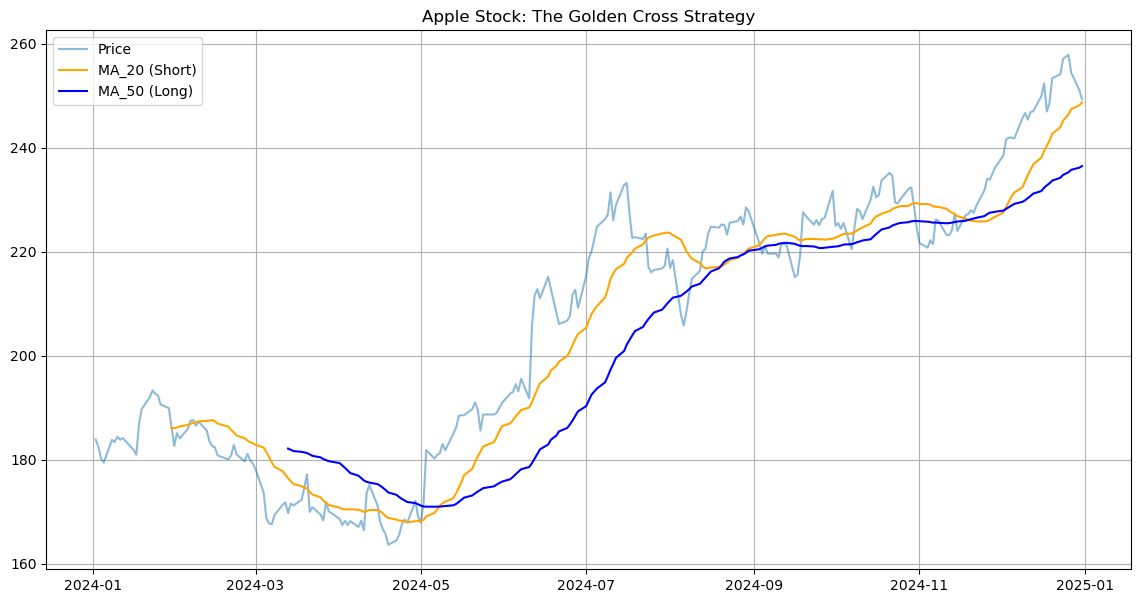

In [5]:
# 2. Plot price along with moving averages
plt.figure(figsize=(14,7))
plt.plot(data["Close"], label="Price", alpha=0.5) # Semi-transparent for background
plt.plot(data["MA20"], label="MA_20 (Short)", color="orange")
plt.plot(data["MA50"], label="MA_50 (Long)", color="blue")

# 3. Optimize visualization
plt.title("Apple Stock: The Golden Cross Strategy")
plt.legend()
plt.grid(True)
#plt.savefig("Figure_2_apple_stock_Golden_Cross.png", dpi=300, bbox_inches='tight')
plt.show()


## Backtest

In [6]:
import numpy as np

In [7]:
# 1. Define signal
# if short term trend > long term trend, Take the Position, else short position
# Warning: Applying .shift(1) is a must in order to avoid look-ahead bias
# It means that you can determine what you should buy today only by moving averages from yesterday data.
data['Signal'] = np.where(data['MA20'] > data['MA50'], 1, 0)
data['Position'] = data['Signal'].shift(1)

# 2. Calculate revenue
# Delta of AAPL price
data['Market_Returns'] = data['Close'].pct_change()
# Your Return = Position * Delta
data['Strategy_Returns'] = data['Position'] * data['Market_Returns']

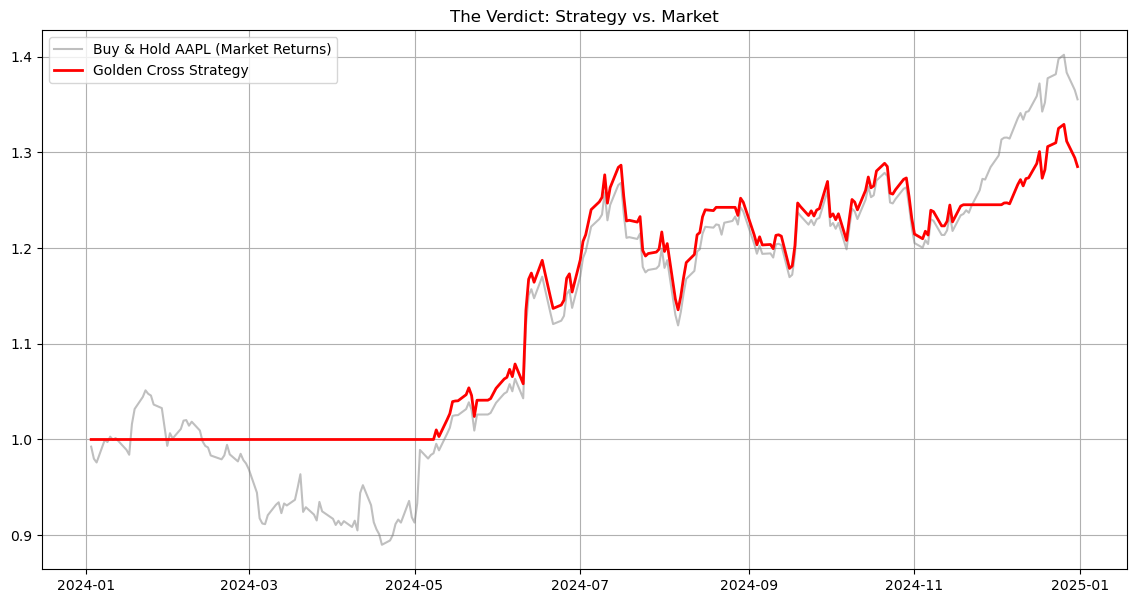

In [8]:
# 3. Calculate cumulative returns
data["Cumulative_Market"] = (1 + data['Market_Returns']).cumprod()
data["Cumulative_Strategy"] = (1 + data['Strategy_Returns']).cumprod()

# 4. Battle of the strategies
plt.figure(figsize=(14,7))
plt.plot(data["Cumulative_Market"], label='Buy & Hold AAPL (Market Returns)', color='grey', alpha=0.5)
plt.plot(data["Cumulative_Strategy"], label='Golden Cross Strategy', color='red', linewidth=2)
plt.title("The Verdict: Strategy vs. Market")
plt.legend()
plt.grid(True)
#plt.savefig("Figure_3_Returns.png", dpi=300, bbox_inches='tight')
plt.show()

In [9]:
# 5. Print return
print(f"If you had held Apple stock continuously, your asset value would have grown to {data['Cumulative_Market'].iloc[-1]:.2f} times the initial investment.")
print(f"If you had applied the dual moving average strategy, your asset value would have grown to {data['Cumulative_Strategy'].iloc[-1]:.2f} times the initial investment.")

If you had held Apple stock continuously, your asset value would have grown to 1.36 times the initial investment.
If you had applied the dual moving average strategy, your asset value would have grown to 1.29 times the initial investment.


## The Math Beast-- Monte Carlo

$$dS_t = \mu S_t dt + \sigma S_t dW_t$$

* $\mu$ (Mu): The drift term, representing the expected long-term average return of the stock.
* $\sigma$ (Sigma): The diffusion term, corresponding to the volatility of the stock.
* $dW_t$: The Wiener process (also known as Brownian motion), representing random incremental disturbances.

In [10]:
# 1. Extract real price over a period of one year, then Compute mu and sigma
log_returns = np.log(1 + data["Close"].pct_change())    # Log return, more mathematically rigourous
mu = log_returns.mean()
var = log_returns.var()
drift = mu - (0.5*var)  # Modifying drift term by Ito lemma
sigma = log_returns.std()

In [11]:
# 2. Set up parameters
days = 252                          # Simulate for next one year (252 trading days)
trials = 100                        # Simulate for 100 times
last_price = data["Close"].iloc[-1] # Starting Price is today's price

In [12]:
# 3. Core magics of math: Geometric Brownian Motion
# Generte Stochastic perturbation
np.random.seed(42)  # For reproducibility
daily_shock = np.random.normal(drift, sigma, (days,trials))
# Convert to price path
price_paths = np.zeros_like(daily_shock)
price_paths[0] = last_price

$S_t = S_{t-1} * e^{(drift + sigma*Z)}$

In [13]:
for t in range(1, days):
    price_paths[t] = price_paths[t-1] * np.exp(daily_shock[t])

In [14]:
# 4. Adding item() is required, otherwise it would occur type errors by matplotlib
last_price_val = last_price.item()

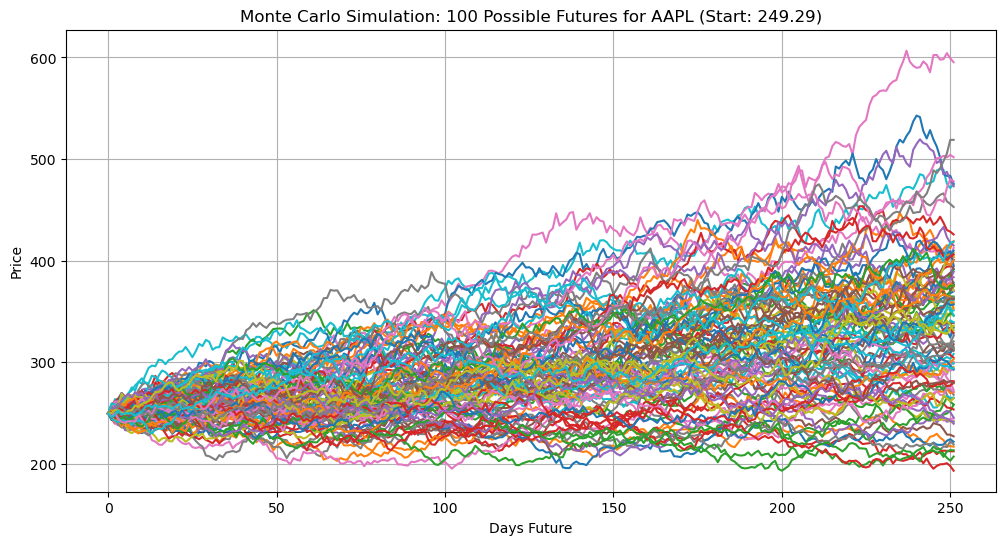

In [15]:
# 5. God Eye View: Plot every possible future price change 
plt.figure(figsize=(12, 6))
plt.plot(price_paths)
plt.xlabel("Days Future")
plt.ylabel("Price")
plt.title(f"Monte Carlo Simulation: 100 Possible Futures for AAPL (Start: {last_price_val:.2f})")
plt.grid(True)
#plt.savefig("Figure_4_Monte_Carlo_Simulation.png", dpi=300, bbox_inches='tight')
plt.show()

In [16]:
# Print confidence interval
print(f"Highest price: {price_paths[-1].max():.2f}")
print(f"Lowest price: {price_paths[-1].min():.2f}")
print(f"Mean price: {price_paths[-1].mean():.2f}")

Highest price: 595.34
Lowest price: 193.04
Mean price: 338.74


## Value at Risk

In [17]:
# 1. Fetch last price
ending_price = price_paths[-1]

# 2. Calculate return from 100 possibilities relative to current starting price
simulated_returns = (ending_price - last_price_val) / last_price_val

# 3. Find the boundary 
# percentile(5) : only 5% situations more terrible than that
var_95 = np.percentile(simulated_returns, 5)

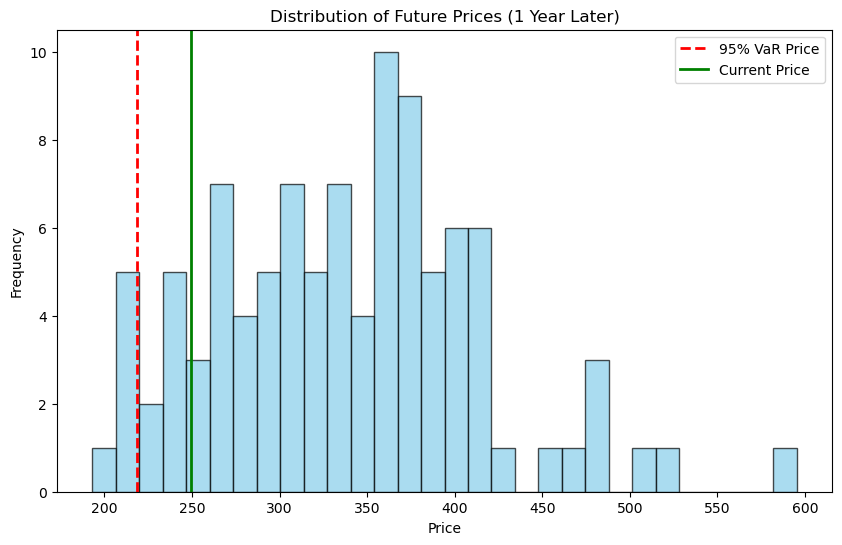

In [18]:
# 4. Visualization
plt.figure(figsize=(10, 6))
plt.hist(ending_price, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(x=last_price_val * (1 + var_95), color='red', linestyle='dashed', linewidth=2, label=f'95% VaR Price')
plt.axvline(x=last_price_val, color='green', linestyle='-', linewidth=2, label='Current Price')
plt.title("Distribution of Future Prices (1 Year Later)")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.legend()
#plt.savefig("Figure_5_Distribution_Future_Prices.png", dpi=300, bbox_inches='tight')
plt.show()

In [19]:
print(f"Current Price: {last_price_val:.2f}")
print(f"95% VaR (Percent): {var_95:.2%}")
print(f"Interpretation: With 95% probability, the asset value will not decline by more than {-var_95:.2%} over the next year.")
print(f"In other words, there is a 5% probability that the asset value will fall to {last_price_val * (1 + var_95):.2f} or lower.")

Current Price: 249.29
95% VaR (Percent): -12.25%
Interpretation: With 95% probability, the asset value will not decline by more than 12.25% over the next year.
In other words, there is a 5% probability that the asset value will fall to 218.76 or lower.
